<a href="https://colab.research.google.com/github/ar040701/Applied-Machine-Learning/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
from torchvision import transforms, models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import zipfile
import os

zip_path = "/content/Places2_simp_resit.zip"
extract_path = "/content/Places2_simp_ayush"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
from torchvision.transforms.v2 import TrivialAugmentWide

transform_train =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20),
    TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset_path = "/content/Places2_simp_ayush/Places2_simp"

dataset =  ImageFolder(root= dataset_path, transform= transform_train)
print(len(dataset))
print(len(dataset.classes))

40000
40


In [6]:
from torch.utils.data import random_split

training_size = int(0.8 * len(dataset))
validation_size = len(dataset) - training_size

train_dataset, val_dataset = random_split(dataset, [training_size, validation_size],  generator=torch.Generator().manual_seed(40))

In [7]:
val_dataset.dataset.transform = transforms_val
train_dataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataLoader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


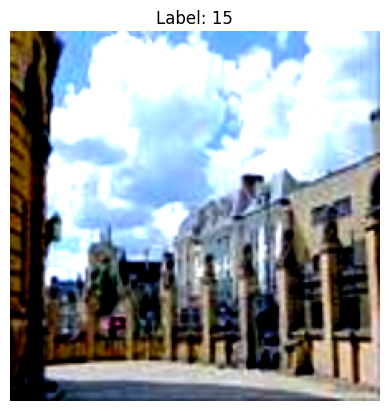

In [8]:
train_features, train_labels = next(iter(train_dataLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
img = img * 0.5 + 0.5
label = train_labels[0]
plt.imshow(img.numpy())
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [9]:
model = models.efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 133MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [10]:

model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
epochs = 10

In [12]:
writer = SummaryWriter("runs/efficientnet")

In [13]:
for epoch in range(epochs):
    print(f"Starting epoch {epoch+1}/{epochs}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_dataLoader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_accuracy = correct / total if total > 0 else 0
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_dataLoader):.4f}, Accuracy: {training_accuracy*100:.2f}%")
    writer.add_scalar("Loss/train", running_loss/len(train_dataLoader), epoch)
    writer.add_scalar("Accuracy/train", training_accuracy, epoch)

    scheduler.step()

Starting epoch 1/10
[Epoch 1] Train Loss: 2.1214, Accuracy: 45.79%
Starting epoch 2/10
[Epoch 2] Train Loss: 1.1188, Accuracy: 67.02%
Starting epoch 3/10
[Epoch 3] Train Loss: 0.8311, Accuracy: 74.83%
Starting epoch 4/10
[Epoch 4] Train Loss: 0.5995, Accuracy: 81.68%
Starting epoch 5/10
[Epoch 5] Train Loss: 0.4980, Accuracy: 84.74%
Starting epoch 6/10
[Epoch 6] Train Loss: 0.4117, Accuracy: 87.53%
Starting epoch 7/10
[Epoch 7] Train Loss: 0.3346, Accuracy: 90.06%
Starting epoch 8/10
[Epoch 8] Train Loss: 0.2965, Accuracy: 91.08%
Starting epoch 9/10
[Epoch 9] Train Loss: 0.2678, Accuracy: 92.12%
Starting epoch 10/10
[Epoch 10] Train Loss: 0.2380, Accuracy: 93.10%


Top-1 Accuracy: 68.95%
Top-5 Accuracy: 93.83%


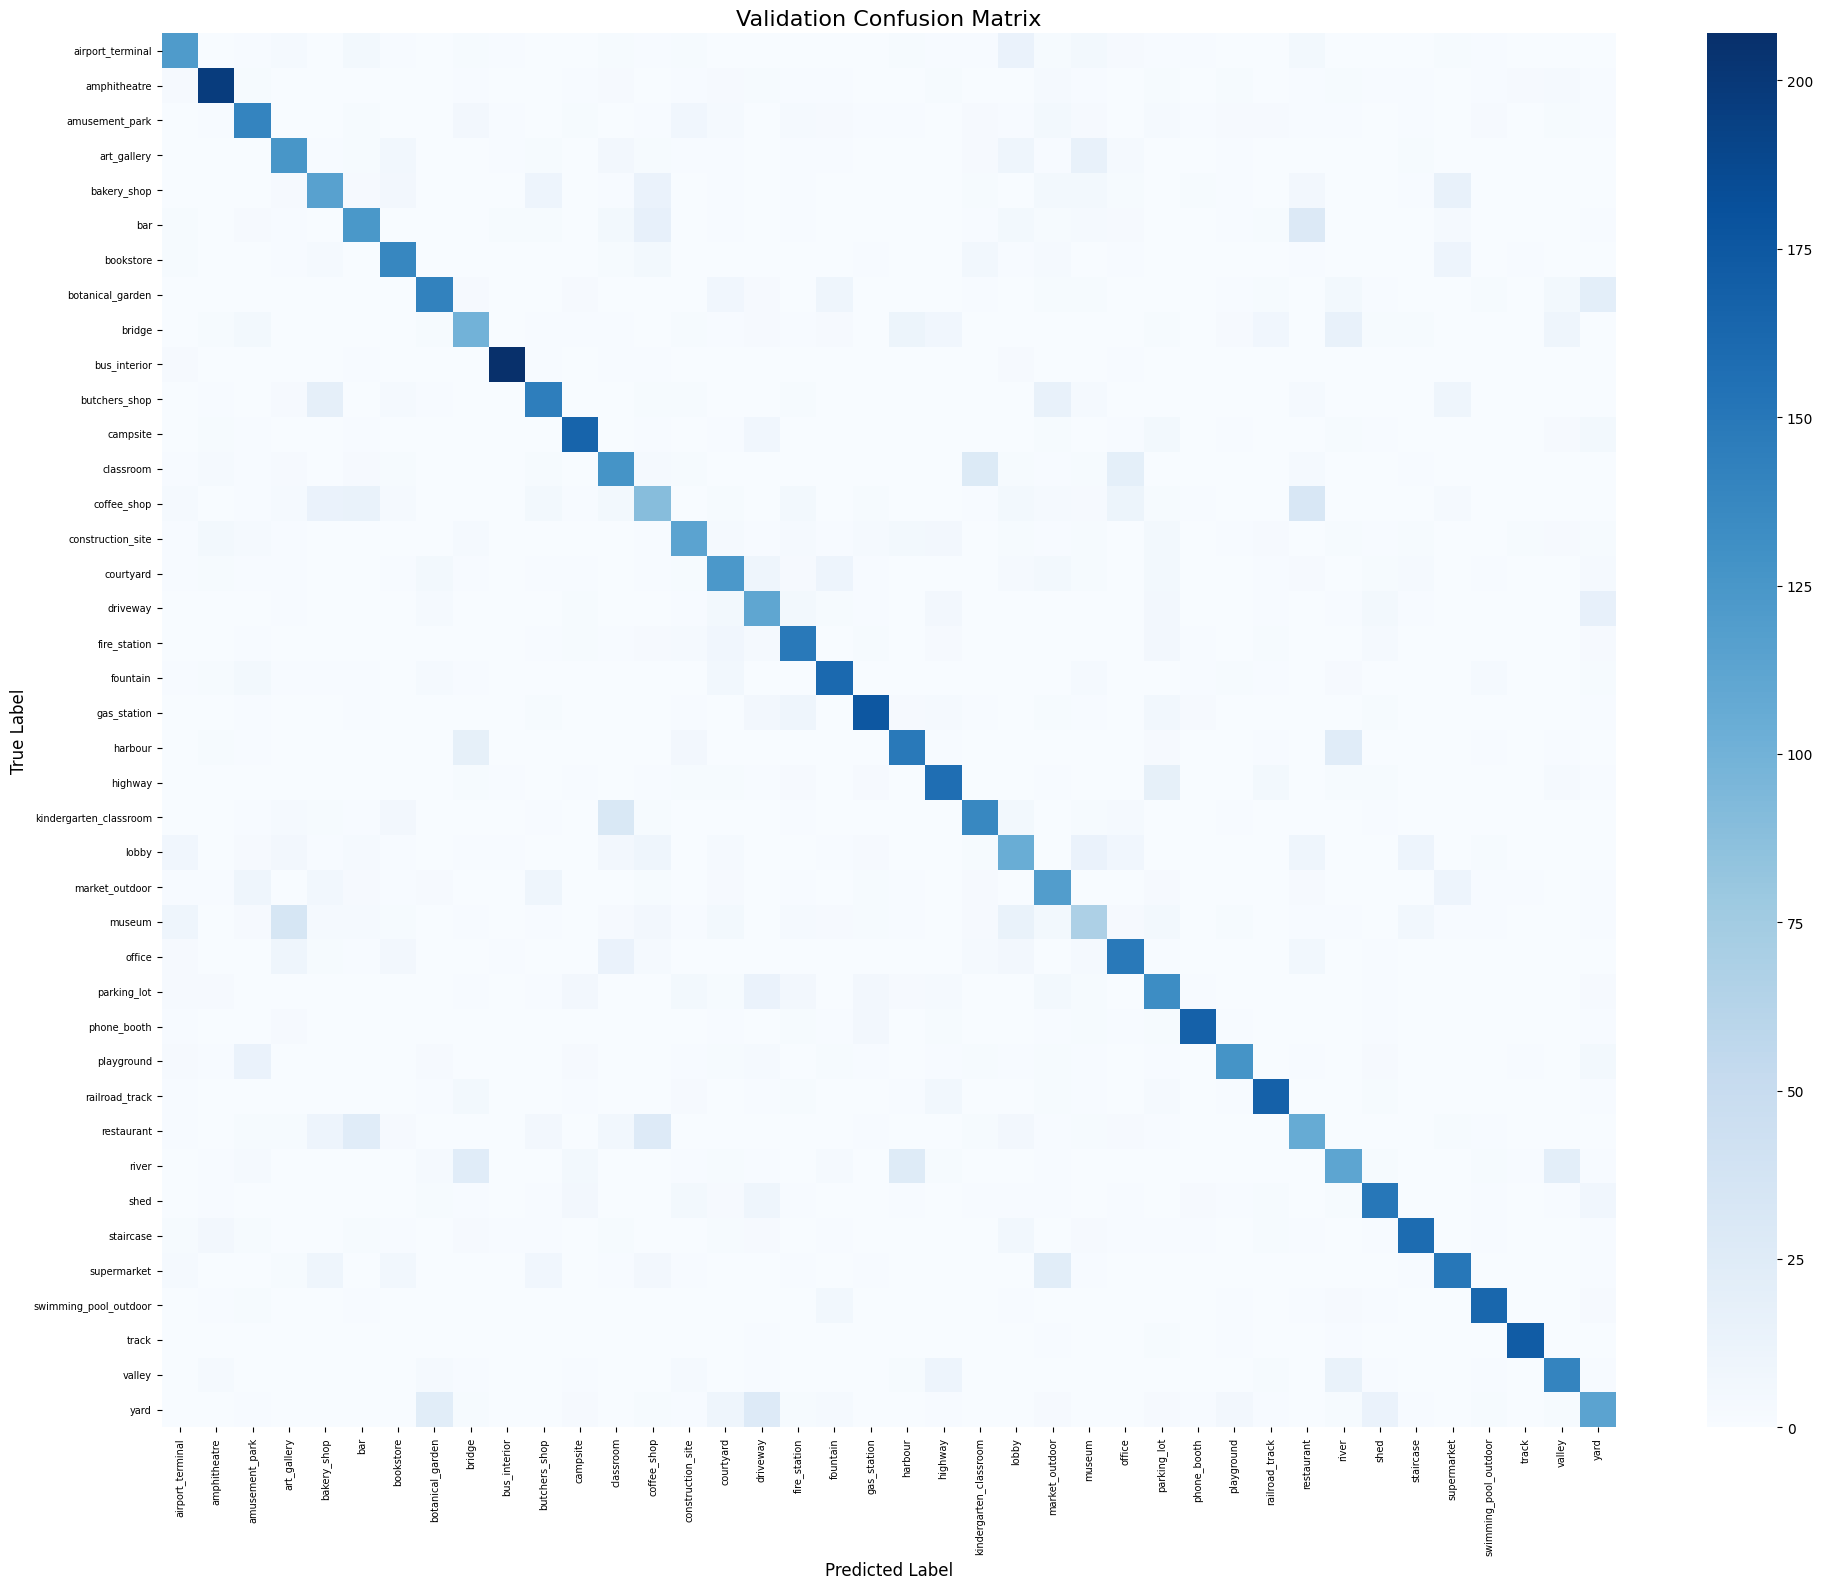

In [14]:
model.eval()
with torch.no_grad():
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for features, labels in val_dataLoader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        total += labels.size(0)

        # Top-1
        predicted1 = outputs.topk(1, dim=1).indices.squeeze()
        top1_correct += (predicted1 == labels).sum().item()

        # Top-5
        top5_pred = outputs.topk(5, dim=1).indices
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted1.cpu().numpy())

top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=val_dataLoader.dataset.dataset.classes,
            yticklabels=val_dataLoader.dataset.dataset.classes)

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.title("Validation Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig("validation_confusion_matrix_efficientnet.png")
plt.show()

writer.close()